# Setup

In [1]:
install_load <- function (package1, ...)  {   

   # convert arguments to vector
   packages <- c(package1, ...)

   # start loop to determine if each package is installed
   for(package in packages){

       # if package is installed locally, load
       if(package %in% rownames(installed.packages()))
          do.call('library', list(package))

       # if package is not installed locally, download, then load
       else {
          install.packages(package)
          do.call("library", list(package))
       }
   } 
}

## Section 11.6

In [9]:
install_load("tidyverse", "parallel", "parallelMap", "mlr", "lasso2", "glmnet")

also installing the dependencies ‘iterators’, ‘foreach’, ‘shape’





The downloaded binary packages are in
	/var/folders/lj/cbwq_6yd37nb5nsnn6y7vx_80000gp/T//Rtmpa4aC4Y/downloaded_packages


Warning message:
“package ‘glmnet’ was built under R version 3.6.2”
Loading required package: Matrix


Attaching package: ‘Matrix’


The following object is masked from ‘package:tidyr’:

    expand


Loaded glmnet 4.0-2



### Listing 11.1

In [5]:
data(Iowa, package = "lasso2")
iowaTib <- as_tibble(Iowa)
iowaTib

Year,Rain0,Temp1,Rain1,Temp2,Rain2,Temp3,Rain3,Temp4,Yield
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1930,17.75,60.2,5.83,69.0,1.49,77.9,2.42,74.4,34.0
1931,14.76,57.5,3.83,75.0,2.72,77.2,3.30,72.6,32.9
1932,27.99,62.3,5.17,72.0,3.12,75.8,7.10,72.2,43.0
1933,16.76,60.5,1.64,77.8,3.45,76.4,3.01,70.5,40.0
1934,11.36,69.5,3.49,77.2,3.85,79.7,2.84,73.4,23.0
1935,22.71,55.0,7.00,65.9,3.35,79.4,2.42,73.6,38.4
1936,17.91,66.2,2.85,70.1,0.51,83.4,3.48,79.2,20.0
1937,23.31,61.8,3.80,69.0,2.63,75.9,3.99,77.8,44.6
1938,18.53,59.5,4.67,69.2,4.24,76.5,3.82,75.7,46.3


### Listing 11.2

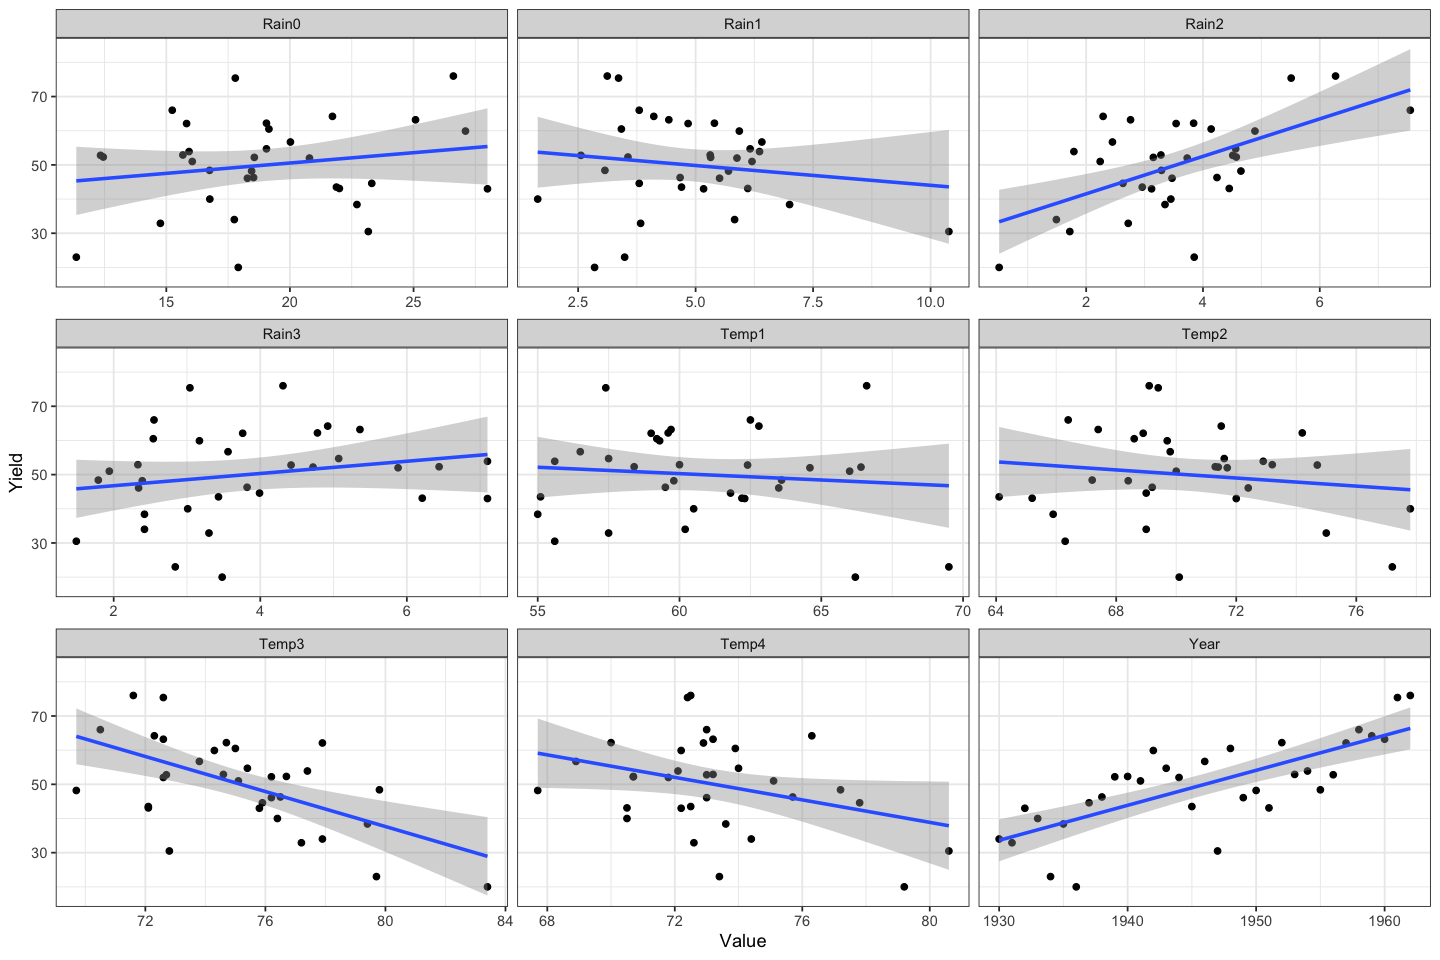

In [7]:
iowaUntidy <- gather(iowaTib, "Variable", "Value", -Yield)

options(repr.plot.width = 12, repr.plot.height = 8)
ggplot(iowaUntidy, aes(Value, Yield)) +
    facet_wrap(~Variable, scales = "free_x") + 
    geom_point() +
    geom_smooth(method = "lm") +
    theme_bw()

## Section 11.6.2

### Listing 11.3

In [10]:
iowaTask <- makeRegrTask(data = iowaTib, target = "Yield")
ridge <- makeLearner("regr.glmnet", alpha = 0, id = "ridge")

Warning message in makeTask(type = type, data = data, weights = weights, blocking = blocking, :
“Provided data is not a pure data.frame but from class tbl_df, hence it will be converted.”


### Listing 11.4

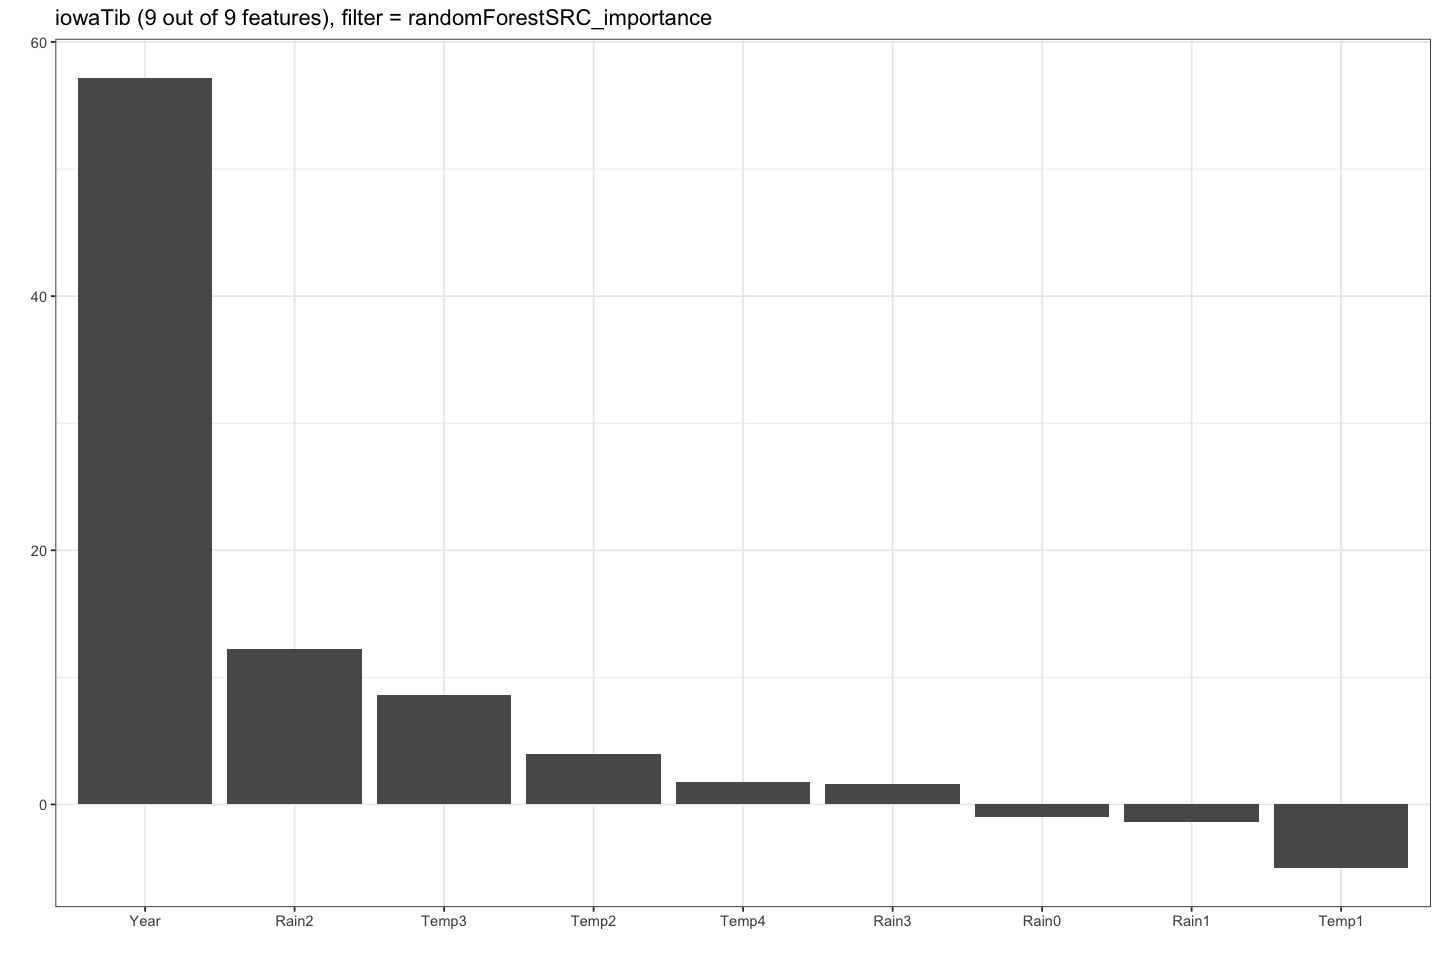

In [11]:
filterVals <- generateFilterValuesData(iowaTask)
plotFilterValues(filterVals) + theme_bw()

### Listing 11.5

In [15]:
ridgeParamSpace <- makeParamSet(
    makeNumericParam("s", lower = 0, upper = 15))
randSearch <- makeTuneControlRandom(maxit = 200)
cvForTuning <- makeResampleDesc("RepCV", folds = 3, reps = 10)

parallelStartSocket(cpus = detectCores())
tunedRidgePars <- tuneParams(ridge, task = iowaTask,
                            resampling = cvForTuning,
                            par.set = ridgeParamSpace,
                            control = randSearch)
parallelStop()

tunedRidgePars

Warning message in parallelStart(mode = MODE_SOCKET, cpus = cpus, socket.hosts = socket.hosts, :
“Parallelization was not stopped, doing it now.”
Stopped parallelization. All cleaned up.

Starting parallelization in mode=socket with cpus=8.

[Tune] Started tuning learner ridge for parameter set:

     Type len Def  Constr Req Tunable Trafo
s numeric   -   - 0 to 15   -    TRUE     -

With control class: TuneControlRandom

Imputation value: Inf

Exporting objects to slaves for mode socket: .mlr.slave.options

Mapping in parallel: mode = socket; level = mlr.tuneParams; cpus = 8; elements = 200.

[Tune] Result: s=7.86 : mse.test.mean=100.1162989

Stopped parallelization. All cleaned up.



Tune result:
Op. pars: s=7.86
mse.test.mean=100.1162989

### Listing 11.6

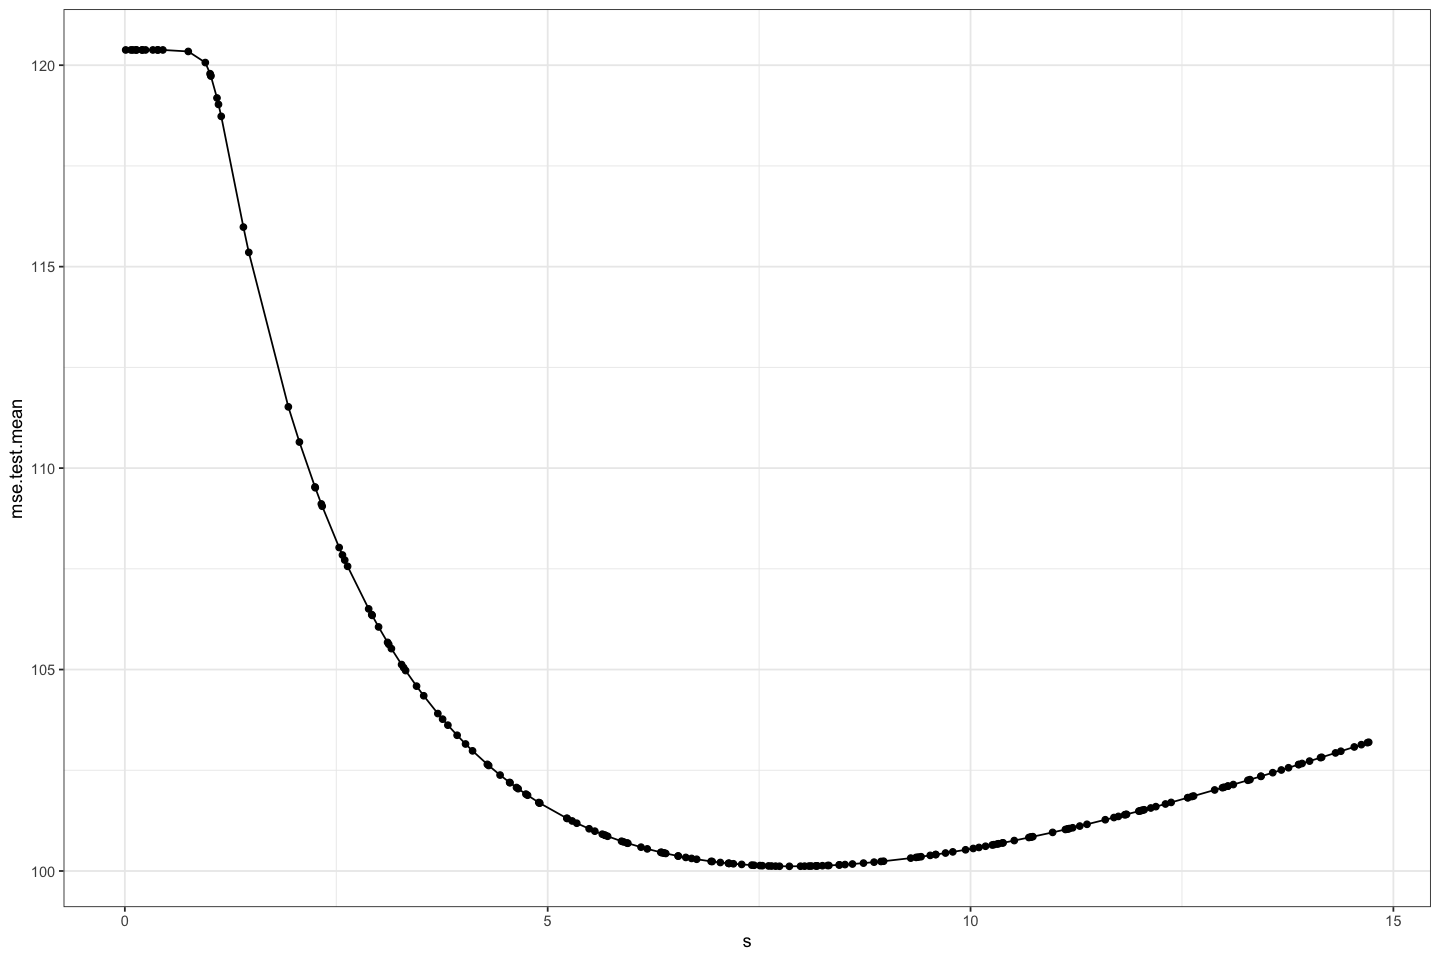

In [17]:
ridgeTuningData <- generateHyperParsEffectData(tunedRidgePars)
plotHyperParsEffect(ridgeTuningData, x = "s", y = "mse.test.mean", plot.type = "line") +
    theme_bw()

### Exercise 1

Starting parallelization in mode=socket with cpus=8.

[Tune] Started tuning learner ridge for parameter set:

     Type len Def  Constr Req Tunable Trafo
s numeric   -   - 0 to 50   -    TRUE     -

With control class: TuneControlRandom

Imputation value: Inf

Exporting objects to slaves for mode socket: .mlr.slave.options

Mapping in parallel: mode = socket; level = mlr.tuneParams; cpus = 8; elements = 200.

[Tune] Result: s=5.57 : mse.test.mean=92.7119930

Stopped parallelization. All cleaned up.



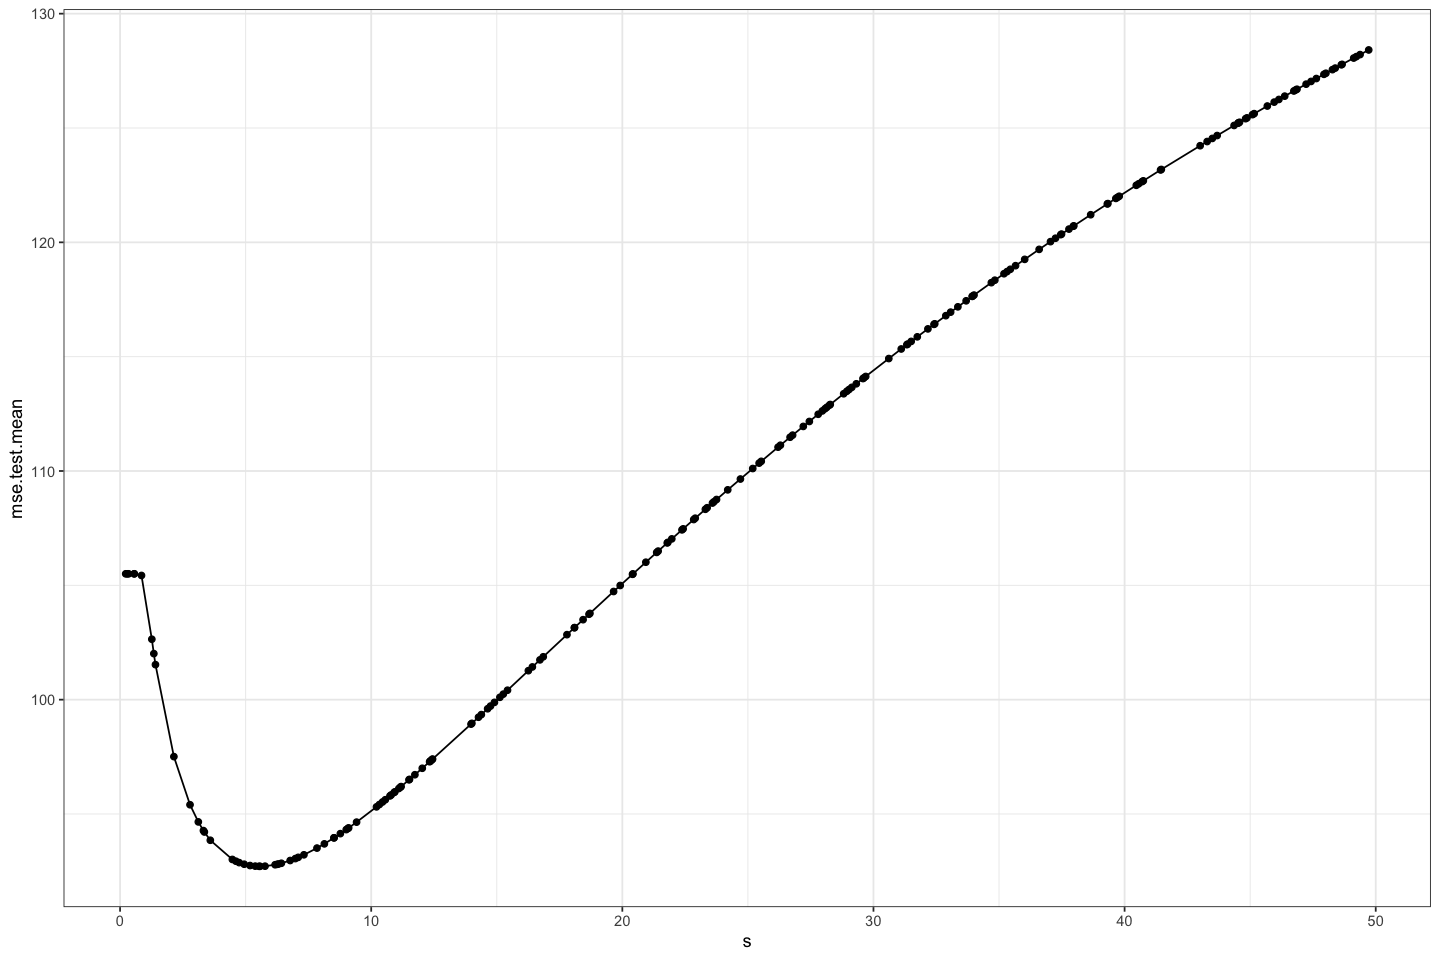

In [18]:
# update search to 50
ridgeParamSpace50 <- makeParamSet(
  makeNumericParam("s", lower = 0, upper = 50))

parallelStartSocket(cpus = detectCores())
tunedRidgePars50 <- tuneParams(ridge, task = iowaTask,
                             resampling = cvForTuning,
                             par.set = ridgeParamSpace50,
                             control = randSearch)
parallelStop()

ridgeTuningData50 <- generateHyperParsEffectData(tunedRidgePars50)
plotHyperParsEffect(ridgeTuningData50, x = "s", y = "mse.test.mean",
                    plot.type = "line") +
  theme_bw()

In [ ]:
# We appear to have found the global minimum

### Listing 11.7

In [19]:
tunedRidge <- setHyperPars(ridge, par.vals = tunedRidgePars$x)
tunedRidgeModel <- train(tunedRidge, iowaTask)

### Listing 11.8

In [21]:
ridgeModelData <- getLearnerModel(tunedRidgeModel)
ridgeCoefs <- coef(ridgeModelData, s = tunedRidgePars$x$s)
ridgeCoefs

10 x 1 sparse Matrix of class "dgCMatrix"
                        1
(Intercept) -8.168526e+02
Year         4.868202e-01
Rain0        3.020449e-01
Temp1       -2.081834e-01
Rain1       -6.530398e-01
Temp2       -3.763457e-03
Rain2        1.825149e+00
Temp3       -6.027374e-01
Rain3        6.226472e-01
Temp4       -4.603575e-01

### Listing 11.9

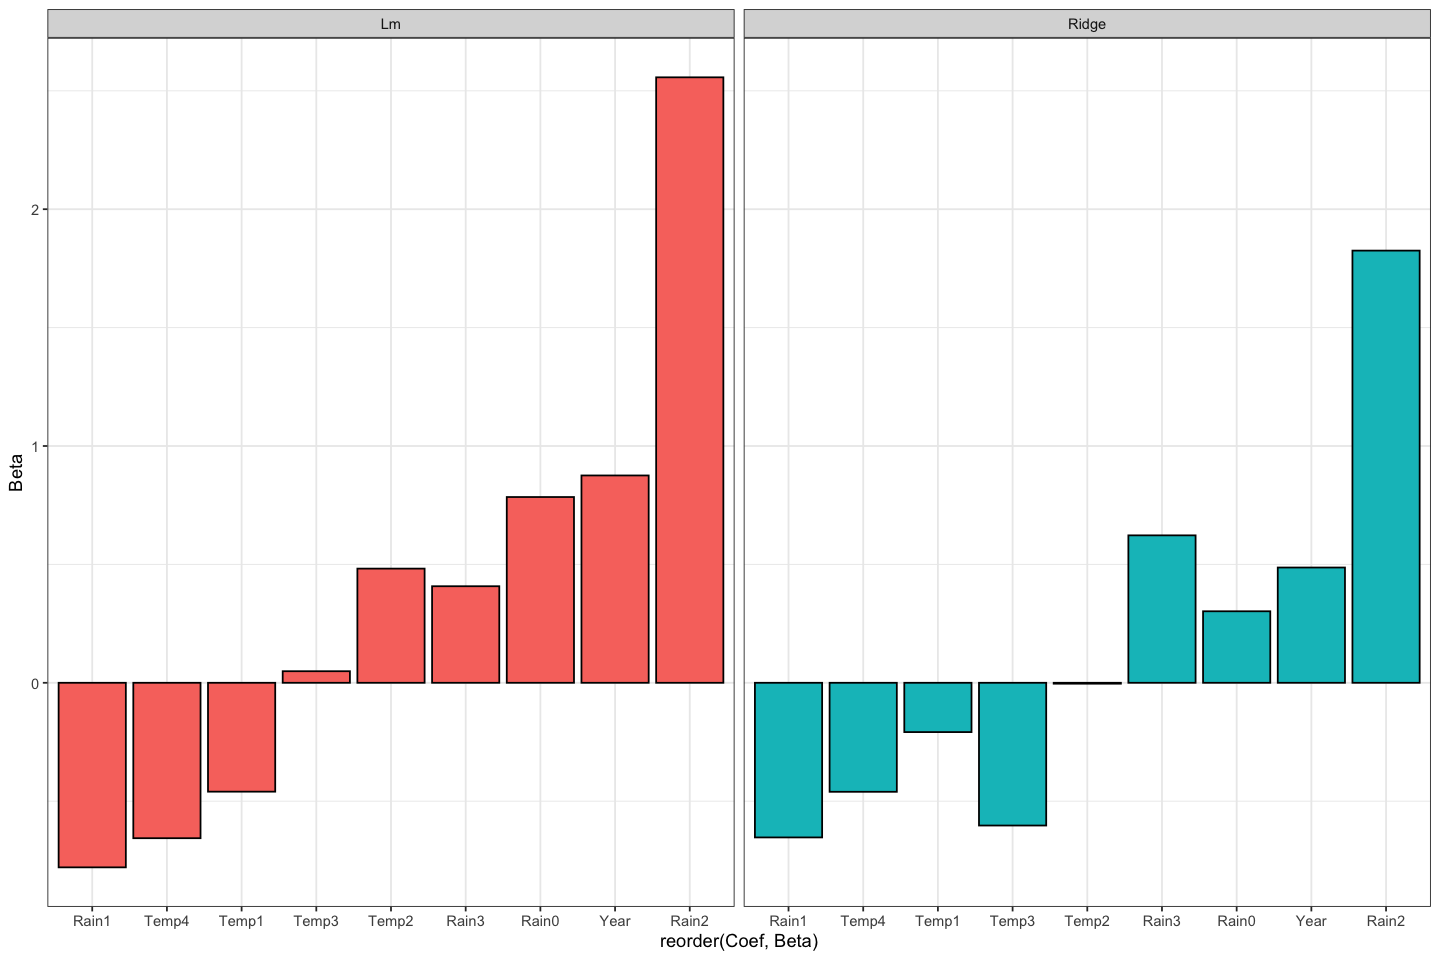

In [23]:
lmCoefs <- coef(lm(Yield ~ ., data = iowaTib))
coefTib <- tibble(Coef = rownames(ridgeCoefs)[-1],
                 Ridge = as.vector(ridgeCoefs)[-1],
                 Lm = as.vector(lmCoefs)[-1])
coefUntidy <- gather(coefTib, key = Model, value = Beta, -Coef)
ggplot(coefUntidy, aes(reorder(Coef, Beta), Beta, fill = Model)) + 
    geom_bar(stat = "identity", col = "black") +
    facet_wrap(~Model) +
    theme_bw() +
    theme(legend.position = "none")

### Exercise 2

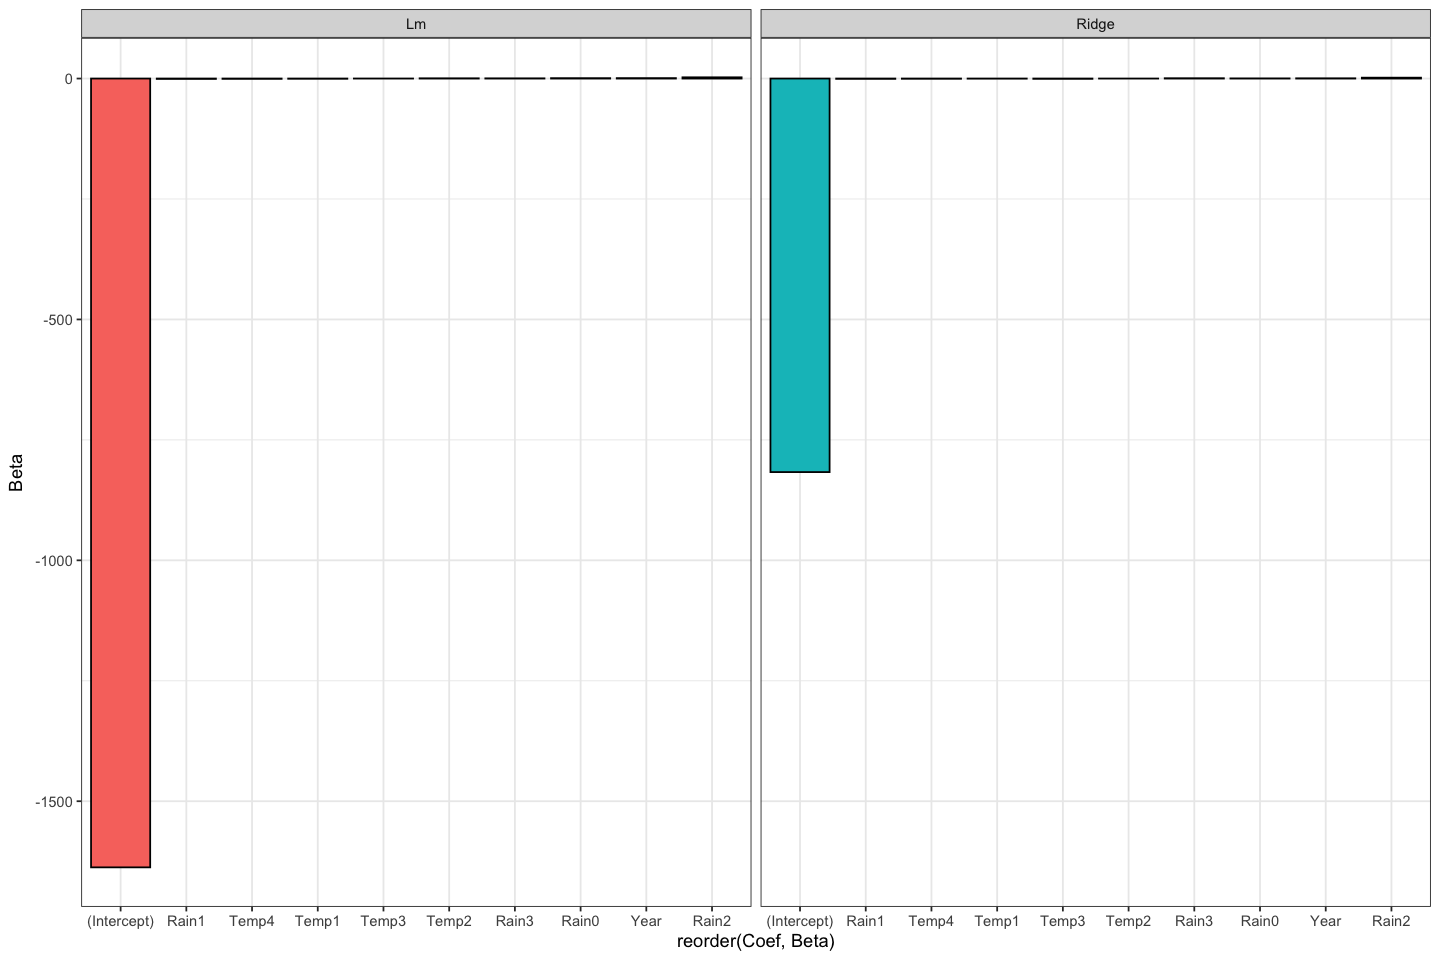

In [25]:
coefTib2 <- tibble(Coef = rownames(ridgeCoefs),
                  Ridge = as.vector(ridgeCoefs),
                  Lm = as.vector(lmCoefs))
coefUntidy2 <- gather(coefTib2, key = Model, value = Beta, -Coef)
ggplot(coefUntidy2, aes(reorder(Coef, Beta), Beta, fill = Model)) + 
    geom_bar(stat = "identity", col = "black") +
    facet_wrap(~Model) +
    theme_bw() +
    theme(legend.position = "none")

In [26]:
coefTib2
# No, including the intercepts completely distorts the model.
# Since the intercept is not interpretable (only the parameter 
# coefficients representing the slopes of each contributing parameter), the
# intercept is an order of magnitude different scale than the other
# parameters

Coef,Ridge,Lm
<chr>,<dbl>,<dbl>
(Intercept),-8.168526e+02,-1.637276e+03
Year,4.868202e-01,8.755817e-01
Rain0,3.020449e-01,7.845010e-01
Temp1,-2.081834e-01,-4.597870e-01
Rain1,-6.530398e-01,-7.794070e-01
Temp2,-3.763457e-03,4.822053e-01
Rain2,1.825149e+00,2.556968e+00
Temp3,-6.027374e-01,4.890862e-02
Rain3,6.226472e-01,4.078031e-01
